In [15]:
import json
import jsonlines
import glob
from collections import defaultdict
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


In [166]:
# Grab all the result files which are labeled in seconds
ageLabels = {
    '3600': 'hour',
    '86400': 'day',
    '603936': 'week',
    '604800': 'week'
}

# Iterate over the folders
data = []
for folder in ['pings-1', 'pings-2', 'pings-3']:
    files = [fn for fn in glob.glob(folder + "/ping.*") if "config" not in fn]

    for fn in files:
        # Parse the file names (should just bake this into the JSON next time...)
        label = fn.split(".")
        location = label[1].split("-")[-1] if label[1] != "fruchter-ipfs-probe" else "chs1"    

        age = label[-2] if label[-1] == '0' else label[-1]
        age = ageLabels[age]

        thisFile = list(jsonlines.open(fn))

        # Unpack attributes into columns
        for observation in thisFile: 
            # Metadata about the ping
            observation['RUN'] = folder
            observation['AGE'] = age
            observation['VP_SHORT'] = location
            observation['VP_COLLAPSED'] = location[0:3]
            # Ping latencies
            if observation['Times']:
                observation['Ping_Mean'] = np.mean(observation['Times'])
                observation['Ping_Stdev'] = np.std(observation['Times'])
                observation['Ping_N'] = len(observation['Times'])
            else:
                observation['Ping_Mean'] = np.nan
                observation['Ping_Stdev'] = np.nan
                observation['Ping_N'] = np.nan

            data.append(observation)


In [174]:
# Turn the data into a dataframe and convert nanoseconds to milliseconds
df = pd.DataFrame(data)
df['Ping_Mean'] = df['Ping_Mean']/1e6
df['Ping_Stdev'] = df['Ping_Stdev']/1e6

# Ping status
df['Success'] = df['Success'].fillna(False)
df['Failed'] = ~df['Success']

# Parse errors to explanations
df['ShortError'] = df[ df.Success == False ]['Error'].str.slice(0,32)
errorTypes = {
    'TIMEOUT': "timeout",
    'Ping error: dial attempt failed:': "peer_unavailable",
    'Ping error: dial backoff': "peer_unavailable",
    'Peer lookup error: routing: not': "peer_unroutable",
    'Peer lookup error: failed to fin': "peer_unroutable",
    'Ping error: max dial attempts ex': "network",
    'Ping error: protocol not support': "network",
    'Ping error: stream reset': "network"
}
df['PingResult'] = df['ShortError'].map(errorTypes).fillna('success')

In [168]:
df.groupby(['AGE','Success']).count()

Address  Error  Ping_Mean  Ping_N  Ping_Stdev    RUN  TIMESTAMP  \
AGE  Success                                                                    
day  False      11077  11077          0       0           0  11077      11077   
     True        2677   2677       2677    2677        2677   2677       2677   
hour False      13323  13323          0       0           0  13323      13323   
     True        3506   3506       3506    3506        3506   3506       3506   
week False      31920  31920          0       0           0  31920      31920   
     True        3342   3342       3342    3342        3342   3342       3342   

              Times  VANTAGE  VP_COLLAPSED  VP_SHORT  Failed  ShortError  
AGE  Success                                                              
day  False    11077    11077         11077     11077   11077       11077  
     True      2677     2677          2677      2677    2677        2677  
hour False    13323    13323         13323     13323   13323       13323  
     True      3506     3506          3506      3506    3506        3506  
week False    31920    31920         31920     31920   31920       31920  
     True      3342     3342          3342      3342    3342        3342

In [169]:
# Aggregate averages 
avgs = df.groupby(['AGE','VP_COLLAPSED']).agg({'Ping_Mean': 'mean', 'Ping_Stdev': 'mean', 'Success': 'sum', 'Failed': 'sum'})
avgs['SuccessfulPings'] = avgs['Success'] / (avgs['Success'] + avgs['Failed'])

In [170]:
avgs.groupby('AGE').agg({'SuccessfulPings': 'mean'})

,SuccessfulPings
AGE,
day,0.276834
hour,0.248540
week,0.106002


In [159]:
avgs

Ping_Mean  Ping_Stdev  Success   Failed  SuccessfulPings
AGE  VP_COLLAPSED                                                           
day  ams           115.464644   44.953905    502.0   1435.0         0.259164
     bom           329.213234   61.937354    175.0    360.0         0.327103
     chs           126.580720   50.232460   1235.0   7514.0         0.141159
     gru           234.319482   53.046716    194.0    482.0         0.286982
     hel           142.749587   44.205196    192.0    455.0         0.296754
     lax           134.929551   41.803361    204.0    450.0         0.311927
     sin           239.563917   63.299334    175.0    381.0         0.314748
hour ams           108.568308   39.235962    489.0   1028.0         0.322347
     bom           307.117944   69.846797    307.0   1305.0         0.190447
     chs           151.298178   60.230578   1629.0   7552.0         0.177432
     gru           260.841090   76.451483    332.0   1050.0         0.240232
     hel           131.311932   47.182860    195.0    306.0         0.389222
     lax           135.965496   45.939072    296.0   1100.0         0.212034
     sin           217.988945   42.224835    258.0    982.0         0.208065
week ams           119.420412   45.307343    806.0   7824.0         0.093395
     bom           293.118593   80.321103    362.0   3333.0         0.097970
     chs           135.069411   62.870837   1075.0  12062.0         0.081830
     gru           236.192017   79.659304    254.0   2067.0         0.109436
     hel           148.695169   62.772922    167.0   1019.0         0.140809
     lax           123.526204   41.743931    388.0   3419.0         0.101918
     sin           221.759095   66.328364    290.0   2196.0         0.116653

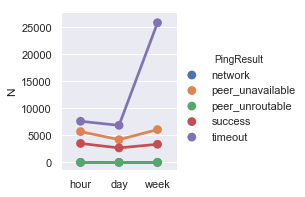

In [274]:
counts = df.groupby(['AGE', 'PingResult']).agg({'PingResult': 'count'})
counts.columns = ['N']
counts = counts.reset_index()

# Create plot of results by time
sns.catplot(data=counts, x='AGE', y='N', hue='PingResult', kind='point', order=['hour', 'day', 'week'], height=3.1).set(xlabel="")

In [243]:
# Map location code region code
region = {'lax': 'na', 'chs1': 'na', 'chs2': 'na', 'ams': 'eu', 'ams2': 'eu', 'hel': 'eu', 'bom': 'ap', 'sin': 'ap', 'gru': 'sa'}
df['RoughRegion'] = df['VP_SHORT'].map(region)
df['RegionLabels'] = df.RoughRegion.map({'na': "NAmerica", "eu":"Europe","sa":"SAmerica","ap":"Asia"})
df['VP'] = df.VP_SHORT.map({'ams': "Europe1", 'bom': "Asia1", 'chs': 'NAmerica1', 'gru': "SAmerica1", 'hel': "Europe2", "lax": "NAmerica2", "sin": "Asia2"})

[Text(0,0.5,''), None, Text(0.5,0,'Mean RTT (ms)')]

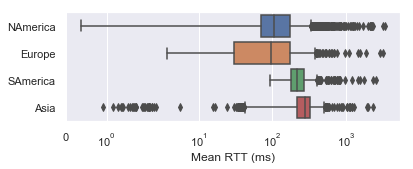

In [275]:
# Boxplot of average ping RTT
sns.set(rc={'figure.figsize':(6,2)})
sns.boxplot(x=df['Ping_Mean'], y=df['RegionLabels']).set(xscale="symlog", xlabel="Mean RTT (ms)", ylabel="")

[Text(0,0.5,''), None, Text(0.5,0,'Latency (ms)')]

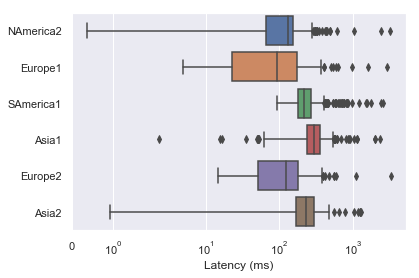

In [239]:
# Boxplot of average ping RTT by region

sns.boxplot(x=df['Ping_Mean'], y=df['VP']).set(xscale='symlog', xlabel="Latency (ms)", ylabel="")

In [237]:
df.head()

,AGE,Address,Error,Ping_Mean,Ping_N,Ping_Stdev,RUN,Success,TIMESTAMP,Times,VANTAGE,VP_COLLAPSED,VP_SHORT,Failed,ShortError,PingResult,RoughRegion,VP
0,week,Qmcj9kKbd8c6RMY1YFahTg8tZj5Pq3pd56rjdsixSJBzTt,TIMEOUT,NaN,NaN,NaN,pings-1,False,1556832609,[],fruchter-ipfs-probe-lax.c.ipri-229620.internal,lax,lax,True,TIMEOUT,timeout,na,NAmerica2
1,week,QmPCYk4h8JH1krqaGRoAVDxk6vF26nN4a3Sm5HvSjxAq8D,TIMEOUT,NaN,NaN,NaN,pings-1,False,1556832616,[],fruchter-ipfs-probe-lax.c.ipri-229620.internal,lax,lax,True,TIMEOUT,timeout,na,NAmerica2
2,week,Qme4zVcSYB9fzSaYiqSqz3phxs31gNzXMsbVH331rt8wo7,Ping error: dial attempt failed: 3 errors occu...,NaN,NaN,NaN,pings-1,False,1556832622,[],fruchter-ipfs-probe-lax.c.ipri-229620.internal,lax,lax,True,Ping error: dial attempt failed:,peer_unavailable,na,NAmerica2
3,week,QmVjPkA5qwawnzE6fpjxDyTWCdSDThqRHPXaDdW9PsRKpy,TIMEOUT,NaN,NaN,NaN,pings-1,False,1556832627,[],fruchter-ipfs-probe-lax.c.ipri-229620.internal,lax,lax,True,TIMEOUT,timeout,na,NAmerica2
4,week,QmcnP4tUyndfoAYE6onVVgbV5nMGRQyR6RjkiJicFwy9X9,TIMEOUT,NaN,NaN,NaN,pings-1,False,1556832633,[],fruchter-ipfs-probe-lax.c.ipri-229620.internal,lax,lax,True,TIMEOUT,timeout,na,NAmerica2
